In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
from glob import glob
history_files = {
    #'ne4np4': glob('data/*.cam.h1.*'),
    'ne4np4': glob('/global/homes/b/bhillma/codes/e3sm/cases/master.FC5AV1C-L.ne4_ne4.cori-knl_intel.16x1.20190430-0930/run/*.cam.h1.*'),
    'ne30np4': glob('/project/projectdirs/m3312/crjones/e3sm/earlyscience.FC5AV1C-L.ne30.sp1_64x1_1000m.20190415/*.cam.h0.*'),
    'ne120np4': glob('/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/*.cam.h0.*'),
    'ne512np4': glob('/global/homes/b/bhillma/codes/e3sm/cases/add-ne512-grids.FC5AV1C-H01A.ne512np4_360x720cru_oRRS15to5.cori-knl_intel.1024x17x8.20190501-0838/run/*.cam.h1.*'),
}
grid_files = {
    #'ne4np4': 'data/ne4np4-pentagons_c100308.nc',
    'ne4np4': '/project/projectdirs/acme/mapping/grids/ne4np4-pentagons_c100308.nc',
    'ne30np4': '/project/projectdirs/acme/mapping/grids/ne30np4_pentagons.091226.nc',
    'ne120np4': '/project/projectdirs/acme/mapping/grids/ne120np4_pentagons.100310.nc',
    'ne512np4': '/project/projectdirs/acme/mapping/grids/ne512np4_scrip_c20190125.nc',
}

from xarray import open_dataset
datasets = {c: open_dataset(history_files[c][0], decode_times=False) for c in history_files.keys()}
grids = {c: open_dataset(grid_files[c]) for c in grid_files.keys()}

In [16]:
# Read data we will use for all examples below
case = 'ne30np4'
variable_name = 'PRECC'
data = datasets[case][variable_name].isel(time=0)
xv = grids[case]['grid_corner_lon'].rename({'grid_size': 'ncol'})
yv = grids[case]['grid_corner_lat'].rename({'grid_size': 'ncol'})

lon = datasets[case]['lon']
lat = datasets[case]['lat']

# Drawing patches on the native grid

In [17]:
datasets[case]

<xarray.Dataset>
Dimensions:          (ilev: 73, lev: 72, nbnd: 2, ncol: 48602, time: 1)
Coordinates:
  * lev              (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * ilev             (ilev) float64 0.1 0.1477 0.218 ... 990.5 997.0 1e+03
  * time             (time) float64 424.0
Dimensions without coordinates: nbnd, ncol
Data variables:
    lat              (ncol) float64 ...
    lon              (ncol) float64 ...
    area             (ncol) float64 ...
    hyam             (lev) float64 ...
    hybm             (lev) float64 ...
    P0               float64 ...
    hyai             (ilev) float64 ...
    hybi             (ilev) float64 ...
    date             (time) int32 ...
    datesec          (time) int32 ...
    time_bnds        (time, nbnd) float64 ...
    date_written     (time) |S8 ...
    time_written     (time) |S8 ...
    ndbase           int32 ...
    nsbase           int32 ...
    nbdate           int32 ...
    nbsec            int32 ...
    mdt        

In [18]:
from matplotlib import pyplot
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection, PolyCollection
from cartopy import crs
import numpy

def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by drawing patches for each
    cell. Note that this will probably be really slow for big grids!
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """
   
    # Create array of cell vertices, indexed [npoints, ncorners, 2]
    corners = numpy.stack([xv.values, yv.values], axis=2)
    
    # Go back and fix corners where they wrap
    for i in range(corners.shape[0]):

        # Fix stuff that wraps around; I should NOT have to do this
        # if I'm using cartopy!
        if any(corners[i,:,0] < 90) and any(corners[i,:,0] > 270):
            corners[i,:,0] = numpy.where(corners[i,:,0] < 90, corners[i,:,0] + 360, corners[i,:,0])
        if any(corners[i,:,1] < -45) and any(corners[i,:,1] > 45):
            corners[i,:,1] = numpy.where(corners[i,:,1] < -45, corners[i,:,1] + 90, corners[i,:,1])
            
    # Create a PatchCollection from our aggregated list of PathPatches
    p = PolyCollection(corners, array=data, antialiaseds=antialiased, **kwargs)

    # Add the collection to the axes
    ax = pyplot.gca()
    ax.add_collection(p)

    # Set sane axes limits
    ax.set_xlim([xv.values.min(), xv.values.max()])
    ax.set_ylim([yv.values.min(), yv.values.max()])
    
    # Return collection of patches
    return p

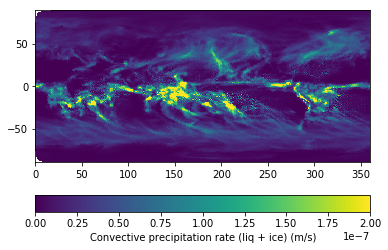

In [26]:
#%%timeit
from cartopy import crs
figure, ax = pyplot.subplots()
pl = plot_unstructured(xv, yv, data, antialiased=False)
pl.set_clim([0, 2e-7])
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))
#pyplot.close()

# Matplotlib Delauney triangulation

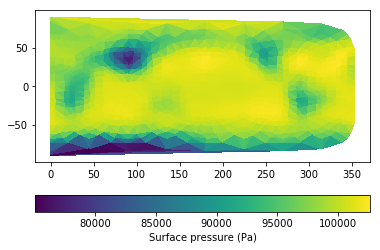

In [6]:
#%%timeit
figure, ax = pyplot.subplots()
pl = ax.tripcolor(lon, lat, data)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))
#pyplot.close()

# Regridding online using griddata

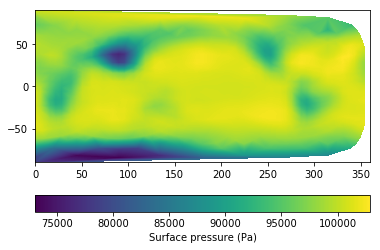

In [7]:
#%%timeit

# Define new grid
xi = numpy.linspace(0, 360, 360*16)
yi = numpy.linspace(-90, 90, 180*16)

# Interpolate to new grid
from scipy.interpolate import griddata
data_regridded = griddata((lon, lat), data, (xi[None,:], yi[:,None]), method='linear')

# Plot on new grid
figure, ax = pyplot.subplots()
pl = ax.pcolormesh(xi, yi, data_regridded)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))

#pyplot.close()

# Timing results

In [8]:
ne = (4, 30, 120)
native_old = (212e-3, 10.1, 134)
native = (69.9e-3, 2.19, 33.6)
delauney = (93e-3, 3.55, 47.7)
griddata_4degree = (51e-3, 952e-3, 12.2)
griddata_1degree = (50.7e-3, 672e-3, 12.2)
griddata_05degree = (69.6e-3, 709e-3, 13.2)
griddata_0125degree = (681e-3, 1.48, 16.8)
griddata_00625degree = (2.65, 3.48, 15.7)

Text(0, 0.5, 'Time to plot (s)')

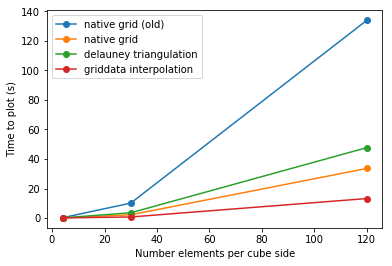

In [9]:
figure, ax = pyplot.subplots()
pl = ax.plot(ne, native_old, 'o-', label='native grid (old)')
pl = ax.plot(ne, native, 'o-', label='native grid')
pl = ax.plot(ne, delauney, 'o-', label='delauney triangulation')
pl = ax.plot(ne, griddata_05degree, 'o-', label='griddata interpolation')
pyplot.legend()
ax.set_xlabel('Number elements per cube side')
ax.set_ylabel('Time to plot (s)')